In [1]:
import numpy as np
import sympy as sp
from scipy import special
from math import *
import matplotlib.pyplot as plt
import cmath as cp
from matplotlib.gridspec import SubplotSpec
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def propTF(u1,L,lambda_,z):
    # propagation - transfer function approach
    # assumes same x and y side lengths and
    # uniform sampling
    # u1 - source plane field
    # L - source and observation plane side length
    # lambda - wavelength
    # z - propagation distance
    # u2 - observation plane field
    M,N =u1.shape                         #get input field array size
    dx=L/M                                #sample interval
    k=(2*pi)/lambda_                      #wavenumber
    fx=np.arange(-1/(2*dx),-1/(2*dx)+(M)*1/L,1/L) #freq coords
    FX,FY=np.meshgrid(fx,fx)
    H=np.exp(-1j*pi*lambda_*z*np.add(np.square(FX),np.square(FY)))  #trans func
    H=np.fft.fftshift(H)                   #shift trans func 
    U1=np.fft.fft2(np.fft.fftshift(u1))    #shift, fft src field
    U2=np.multiply(H,U1)                   #multiply
    u2=np.fft.ifftshift(np.fft.ifft2(U2))  #inv fft, center obs field
    return u2

In [3]:
def circ(r):
    out=(np.where(abs(r)<=1, 1, 0))
    return out

In [4]:
def rect(x):
    out = np.where(abs(x)<=0.5, 1, 0)
    return out

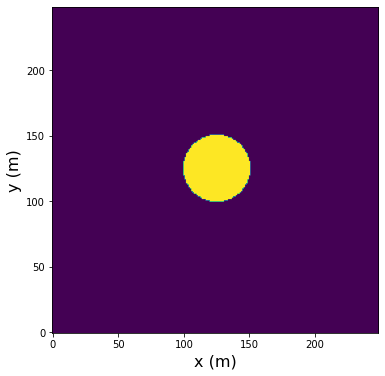

In [5]:
#sqr_beam propagation example
w = 0.0125
L1 = 40*w
#L1=0.5
M=250
dx1=L1/M
x1 = np.arange(-L1/2,L1/2-dx1,dx1)
y1=x1

lambda_=0.5e-6 #wavelength
k=2*pi/lambda_ #wavenumber
w=0.051 #source half width (m)
z=2000 #propagation dist (m)

X1,Y1=np.meshgrid(x1,y1)
#u1=np.multiply(rect(X1/(2*w)),rect(Y1/(2*w))) #src field
#u1 = circ(np.sqrt(np.add(np.square(X1),np.square(Y1)))/w)
u1 = circ(np.sqrt(np.add(np.square(X1),np.square(Y1)))/w)
I1=abs(np.square(u1)) #src irradiance

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6, 6))
img1 = axes.imshow(I1,origin='lower')
axes.set_xlabel("x (m)",fontsize=16)
axes.set_ylabel("y (m)",fontsize=16)
plt.show()

(249,)


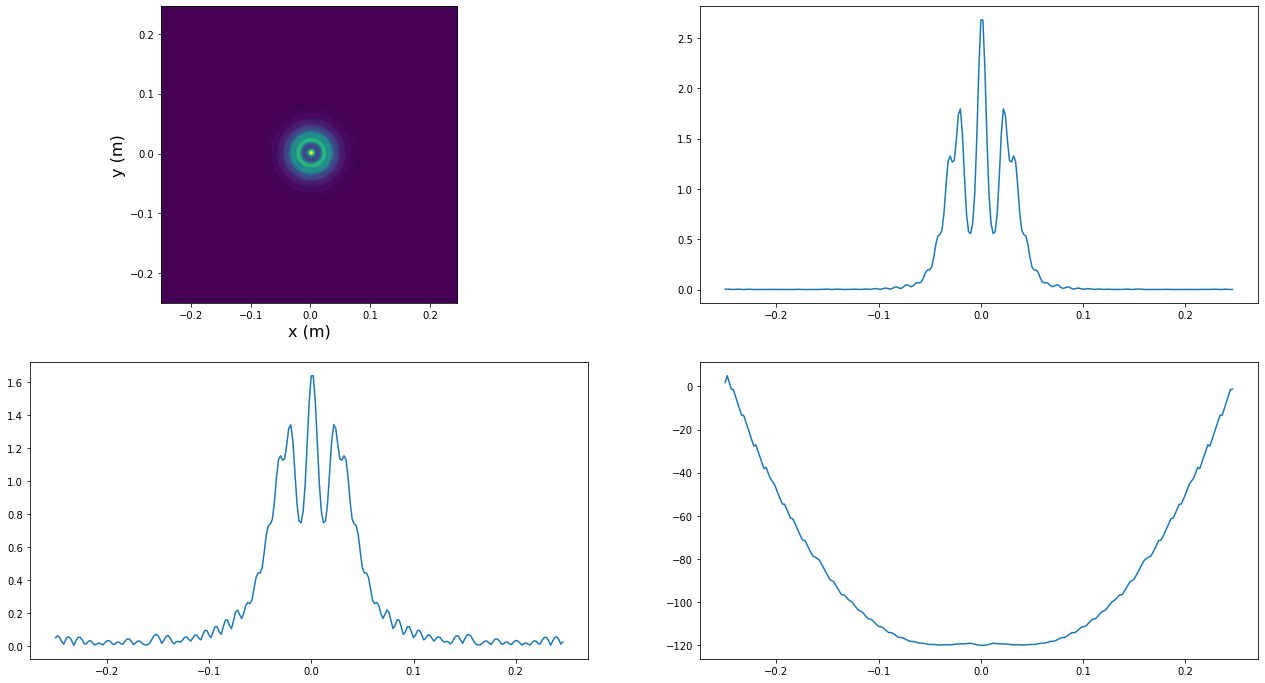

In [6]:
u2=propTF(u1,L1,lambda_,z) #propagation

x2=x1
y2=y1
I2=abs(np.square(u2))

slice_ = int(M/2)

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(22, 12))

img1 = axes[0,0].imshow(I2, extent = [min(x2),max(x2),min(y2),max(y2)],origin='lower')
axes[0,0].set_xlabel("x (m)",fontsize=16)
axes[0,0].set_ylabel("y (m)",fontsize=16)

y_ = I2[slice_,:]
axes[0,1].plot(x2,y_)


y_ = abs(u2[slice_,:])
axes[1,0].plot(x2,y_)


y_ = np.angle(u2[slice_,:])
axes[1,1].plot(x2,np.unwrap(y_))

plt.show()

(500,)


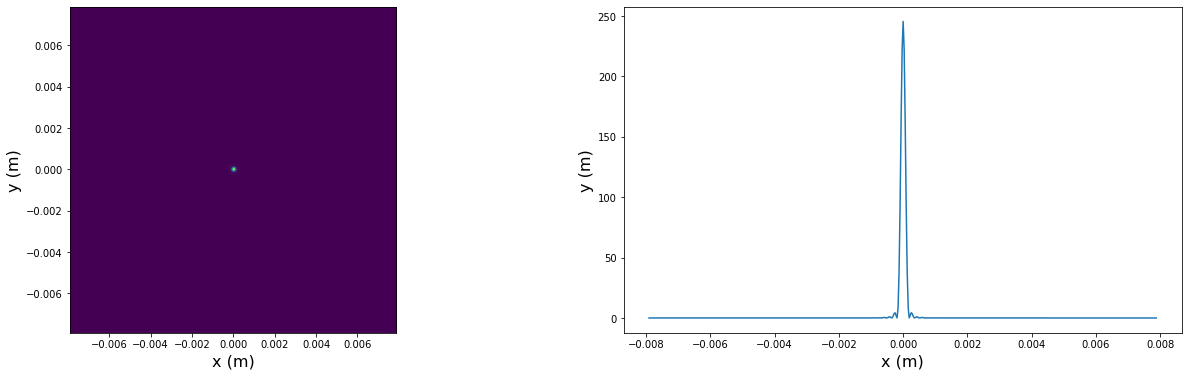

In [25]:
N=500                        #samples 1D 
lambda_= 0.5e-6              #wavelength
k= (2*pi)/lambda_            #wavenumber
f=1                          #Focal length of lens
L=sqrt(N*lambda_*f)          #spatial grid side length

dx=L/N                       #sample interval
x = np.linspace(-L/2,L/2-dx,N)  #linear coordinates
y = x
X, Y= np.meshgrid(x,x)        #2D cordinates

z=0
A=np.ones(N)
U=A*np.exp(-1j*k*z);          #plane wave field 

w=L/10                   #lens radius
P=circ(np.sqrt(np.square(X)+np.square(Y))/w) #pupil function

t_lens=np.multiply(P,np.exp(-1j*k/(2*f)*np.add(np.square(X),np.square(Y)))) #transmittance function
U1=np.multiply(U,t_lens)      #Field after lens


U2=propTF(U1,L,lambda_,f)     # Field at a distance f from lens
I_b=np.square(abs(U2))        # Intensity at a distance f from lens


fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(22, 6))
img1 = axes[0].imshow(I_b, extent = [min(x),max(x),min(y),max(y)],origin='lower') #display intensity
axes[0].set_xlabel("x (m)",fontsize=16)
axes[0].set_ylabel("y (m)",fontsize=16)

slice_ = int(N/2)            
y_ = I_b[slice_,:]
axes[1].plot(x,y_)
axes[1].set_xlabel("x (m)",fontsize=16)
axes[1].set_ylabel("y (m)",fontsize=16)

plt.show()

In [8]:
I_b

array([[0.000196  , 0.00019355, 0.00018634, ..., 0.00017474, 0.00018634,
        0.00019355],
       [0.00019355, 0.00019113, 0.000184  , ..., 0.00017253, 0.000184  ,
        0.00019113],
       [0.00018634, 0.000184  , 0.0001771 , ..., 0.000166  , 0.0001771 ,
        0.000184  ],
       ...,
       [0.00017474, 0.00017253, 0.000166  , ..., 0.00015552, 0.000166  ,
        0.00017253],
       [0.00018634, 0.000184  , 0.0001771 , ..., 0.000166  , 0.0001771 ,
        0.000184  ],
       [0.00019355, 0.00019113, 0.000184  , ..., 0.00017253, 0.000184  ,
        0.00019113]])

In [9]:
def jinc(x):
    #jinc function
    #evaluates J1(2*pi*x)/x with divide by zero fix
    #locate non-zero elements of x
    index = np.nonzero(x == 0)
    x1=(np.where(x==0, -1, x))
    #compute output values for all other x
    out = np.divide(special.jv(1, 2*pi*x1),x1)
    out[index] = pi
    return out

In [10]:
a1 = np.square(w)/(lambda_*f)
a2_ = (w/(lambda_*f))*np.sqrt(np.add(np.square(X),np.square(Y)))
a2 = jinc(a2_)
I2_th = np.square(a1)*np.square(a2)


array([[1.36452904e-05, 1.28904804e-05, 1.18483010e-05, ...,
        1.05702042e-05, 1.18483010e-05, 1.28904804e-05],
       [1.28904804e-05, 1.18435821e-05, 1.05590579e-05, ...,
        9.10079699e-06, 1.05590579e-05, 1.18435821e-05],
       [1.18483010e-05, 1.05590579e-05, 9.09463620e-06, ...,
        7.52846159e-06, 9.09463620e-06, 1.05590579e-05],
       ...,
       [1.05702042e-05, 9.10079699e-06, 7.52846159e-06, ...,
        5.93273446e-06, 7.52846159e-06, 9.10079699e-06],
       [1.18483010e-05, 1.05590579e-05, 9.09463620e-06, ...,
        7.52846159e-06, 9.09463620e-06, 1.05590579e-05],
       [1.28904804e-05, 1.18435821e-05, 1.05590579e-05, ...,
        9.10079699e-06, 1.05590579e-05, 1.18435821e-05]])

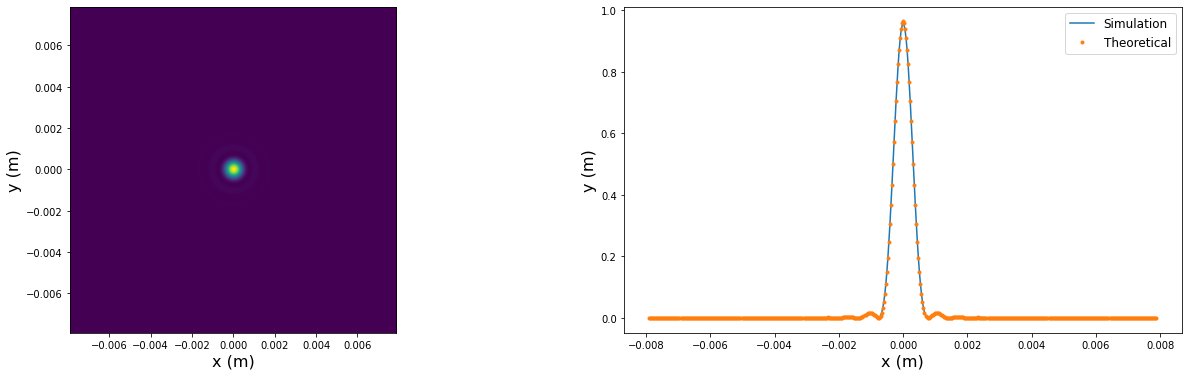

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(22, 6))

img1 = axes[0].imshow(I2_th, extent = [min(x),max(x),min(y),max(y)],origin='lower') #display intensity
axes[0].set_xlabel("x (m)",fontsize=16)
axes[0].set_ylabel("y (m)",fontsize=16)

slice_ = int(N/2)
y1_ = I_b[slice_,:]
y_ = I2_th[slice_,:]
axes[1].plot(x,y1_)
axes[1].plot(x,y_,'.')
axes[1].set_xlabel("x (m)",fontsize=16)
axes[1].set_ylabel("y (m)",fontsize=16)
axes[1].legend(['Simulation', 'Theoretical'],fontsize = 12)

plt.show()